In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import fbeta_score, make_scorer
import warnings
warnings.filterwarnings("ignore")

Для машинного обучения мы будем использовать датафрейм ready.csv, который мы подготовили в тетрадке main_project. 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/pavleke-all_tables/ready.csv')

In [3]:
df.head()

,Unnamed: 0,raceId,constructorId,driverId,year,resultId,grid,positionOrder,status,status_short,...,abs_overtakings,overtakings_only_positive,avTeamQualiMill,avPosTeamRace,diffPosOrder,diffQualiMill,avTimeByQuali,driverTimeMillNormed,is_podium,win
0,0,1,1,1,2009,7573,18,20,Disqualified,rules,...,2,0,86319.0,19.5,-0.5,-0.001562,86041.75,1.004791,0.0,0.0
1,17,1,1,5,2009,7572,12,19,Collision,collision,...,7,0,86319.0,19.5,0.5,0.001566,86041.75,1.001653,0.0,0.0
2,622,1,2,2,2009,7563,9,10,Finished,finished,...,1,0,85874.5,12.0,2.0,0.000553,86041.75,0.997504,0.0,0.0
3,639,1,2,9,2009,7567,4,14,Collision,collision,...,10,0,85874.5,12.0,-2.0,-0.000553,86041.75,0.998608,0.0,0.0
4,1045,1,3,3,2009,7559,5,6,Finished,finished,...,1,0,85960.0,12.0,6.0,0.001328,86041.75,0.997725,0.0,0.0


In [4]:
df['weather_main'].fillna('', inplace=True)

Удалим статусы, потому что до начала гонки мы не знаем, как она закончится

In [5]:
df.drop(['status', 'status_short'], axis=1, inplace=True)

In [6]:
df.fillna(0, inplace=True)

Удалим признаки, которые были выведены непосредственно из признака 'positionOrder', то есть те, при подсчете которых учитывались итоговые результаты гонок

Преобразуем столбцы с категориальными данными (weather_main) с помощью ONE-HOT кодирования

In [7]:
df_dum = pd.get_dummies(df, drop_first=True)
print(f"Data shape: {df_dum.shape}")
df_dum.head()

Data shape: (26097, 33)


,Unnamed: 0,raceId,constructorId,driverId,year,resultId,grid,positionOrder,circuitId,debut_raceId,...,avPosTeamRace,diffPosOrder,diffQualiMill,avTimeByQuali,driverTimeMillNormed,is_podium,win,weather_main_changing,weather_main_dry,weather_main_wet
0,0,1,1,1,2009,7573,18,20,1,36,...,19.5,-0.5,-0.001562,86041.75,1.004791,0.0,0.0,0,1,0
1,17,1,1,5,2009,7572,12,19,1,36,...,19.5,0.5,0.001566,86041.75,1.001653,0.0,0.0,0,1,0
2,622,1,2,2,2009,7563,9,10,1,158,...,12.0,2.0,0.000553,86041.75,0.997504,0.0,0.0,0,1,0
3,639,1,2,9,2009,7567,4,14,1,65,...,12.0,-2.0,-0.000553,86041.75,0.998608,0.0,0.0,0,1,0
4,1045,1,3,3,2009,7559,5,6,1,53,...,12.0,6.0,0.001328,86041.75,0.997725,0.0,0.0,0,1,0


In [8]:
df_dum.drop(['positionOrder', 'diffPosOrder', 'avPosTeamRace', 'overtakings', 'abs_overtakings', 'overtakings_only_positive'], axis=1, inplace=True)

Сначала будем делить на train и test только список raceId, чтобы в тренировочную и тестовую выборку попали гонки целиком, потому что иначе предсказание потеряет смысл

In [9]:
raceId_train, raceId_test = train_test_split(df_dum['raceId'].unique(), test_size=0.3, random_state=13)

In [10]:
raceId_train = list(raceId_train)
raceId_test = list(raceId_test)

Теперь разделим сами выборки на тестовую и тренировочную на основе полученных raceId

In [11]:
df_train = df_dum[df_dum['raceId'].isin(raceId_train)]
df_test = df_dum[df_dum['raceId'].isin(raceId_test)]

Разделим выборки на Х и у. в у1 находится колонка 'win', в y2 - колонка 'is_podium'

In [12]:
X_train = df_train.drop(['win', 'is_podium'], axis=1)
X_test = df_test.drop(['win', 'is_podium'], axis=1)
y1_train = df_train['win']
y1_test = df_test['win']
y2_train = df_train['is_podium']
y2_test = df_test['is_podium']

Изменим тип данных для некоторых столбцов на str, чтобы при дальнейшем масштабировании эти признаки не изменились (так как они скорее категориальные, чем количественные, так как показывают id)

In [13]:
X_test[['raceId', 'constructorId', 'driverId', 'resultId', 'circuitId']] = X_test[['raceId', 'constructorId', 'driverId', 'resultId', 'circuitId']].astype('str')

In [14]:
X_train[['raceId', 'constructorId', 'driverId', 'resultId', 'circuitId']] = X_train[['raceId', 'constructorId', 'driverId', 'resultId', 'circuitId']].astype('str')

Используем StandardScaler() для масштабирования признаков

In [15]:
ss = StandardScaler()
X_train_new_s = ss.fit_transform(X_train)
X_test_new_s = ss.transform(X_test)

In [16]:
model1 = LogisticRegression()
model1.fit(X_train_new_s, y1_train)
probs = model1.predict_proba(X_test_new_s)
winner = probs[:, 1]
y1_pred = model1.predict(X_test_new_s)

In [17]:
roc_auc = roc_auc_score(y1_test, winner)
accuracy = accuracy_score(y1_test, y1_pred)
precision = precision_score(y1_test, y1_pred)
recall = recall_score(y1_test, y1_pred)
print('ROC_AUC = %.4f' % roc_auc)
print('accuracy = %.4f' % accuracy)
print('precision = %.4f' % precision)
print('recall = %.4f' % recall)

ROC_AUC = 0.9308
accuracy = 0.9587
precision = 0.5652
recall = 0.0398


Как мы видим ниже, из 324 гонок модель предсказывает только 23 победителей, потому что граница принятия решений выбрана равной 0.5

In [18]:
len(pd.DataFrame(y1_pred)[pd.DataFrame(y1_pred)[0] == 1])

23

Попробуем на основе полученных моделью вероятностей сделать так, чтобы гонщик, у которого максимальная вероятность победить считался победителем гонки

In [19]:
res = pd.DataFrame((X_test.reset_index()).merge(pd.DataFrame(winner), right_index=True, left_index=True))
res.rename(columns={0: 'prob_win_predicted'}, inplace=True)

In [20]:
max_prob_win = pd.DataFrame(res.groupby('raceId')['prob_win_predicted'].max())

In [21]:
max_prob_win.rename(columns={'prob_win_predicted': 'max_prob_win'}, inplace=True)
res = res.merge(max_prob_win, right_index=True, left_on='raceId', how='outer')

In [22]:
res.loc[res['prob_win_predicted'] == res['max_prob_win'], 'winner'] = 1
res['winner'].fillna(0, inplace=True)

In [23]:
roc_auc = roc_auc_score(y1_test, winner)
accuracy = accuracy_score(y1_test, res['winner'])
precision = precision_score(y1_test, res['winner'])
recall = recall_score(y1_test,  res['winner'])
print('ROC_AUC = %.4f' % roc_auc)
print('accuracy = %.4f' % accuracy)
print('precision = %.4f' % precision)
print('recall = %.4f' % recall)

ROC_AUC = 0.9308
accuracy = 0.9542
precision = 0.4506
recall = 0.4465


Будем искать лучшие параметры для логистической регрессии с помощью GridSearch

In [24]:
beta_scorer = make_scorer(fbeta_score, beta=5) #создаем бета scorer, чтобы подставить в gridsearch

In [25]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
model_search = LogisticRegression()

searcher_solv = GridSearchCV(model_search, param_grid={"solver": solvers},
                        scoring=beta_scorer, cv=4)
searcher_solv.fit(X_train_new_s, y1_train)

best_solver = searcher_solv.best_params_["solver"]

best_solver

'newton-cg'

In [29]:
# Теперь найдем оптимальные параметры, зная, что оптимальный solver - 'newton-cg'
from numpy.random import randint
np.random.seed(13)
model_ = LogisticRegression(solver='newton-cg')
penalty = [None, 'l2']
C = np.logspace(-7, 7, 20)
tol = np.logspace(-5, 5, 30)
i_s = np.logspace(-2, 5, 30)
max_iter = np.random.randint(500, size=20)
multi_class = ['auto', 'ovr', 'multinomial']

In [27]:
searcher_pen = GridSearchCV(model_, param_grid={"penalty": penalty}, scoring=beta_scorer, cv=4)
searcher_pen.fit(X_train_new_s, y1_train)
best_penalty = searcher_pen.best_params_['penalty']
print('best_penalty = ', best_penalty)

best_penalty =  None


In [28]:
searcher_C = GridSearchCV(model_, param_grid={"penalty": penalty, 'C': C}, scoring=beta_scorer, cv=4)
searcher_C.fit(X_train_new_s, y1_train)
best_C = searcher_C.best_params_['C']
print('best_C = %.4f' % best_C)

best_C = 517.9475


best_tol = 0.0281


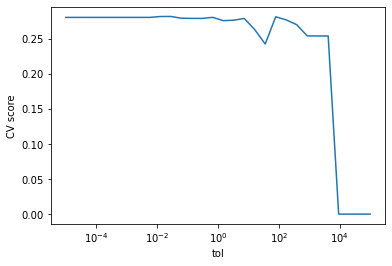

In [30]:
searcher_tol = GridSearchCV(model_, param_grid={'tol': tol}, scoring=beta_scorer, cv=4)
searcher_tol.fit(X_train_new_s, y1_train)
best_tol = searcher_tol.best_params_['tol']
print('best_tol = %.4f' % best_tol)
plt.plot(tol, searcher_tol.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("tol")
plt.ylabel("CV score");

intercept_scaling = 0.0100


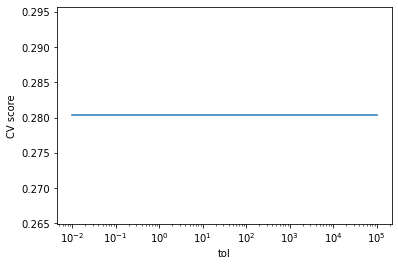

In [31]:
searcher_is = GridSearchCV(model_, param_grid={'intercept_scaling': i_s}, scoring=beta_scorer, cv=4)
searcher_is.fit(X_train_new_s, y1_train)
best_is = searcher_is.best_params_['intercept_scaling']
print('intercept_scaling = %.4f' % best_is)
plt.plot(i_s, searcher_is.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("tol")
plt.ylabel("CV score");

best_max_iter: = 338.0000


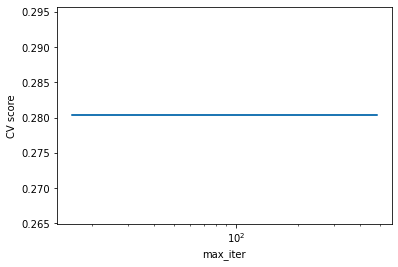

In [32]:
searcher_mi = GridSearchCV(model_, param_grid={'max_iter': max_iter}, scoring=beta_scorer, cv=4)
searcher_mi.fit(X_train_new_s, y1_train)
best_mi = searcher_mi.best_params_['max_iter']
print('best_max_iter: = %.4f' % best_mi)
plt.plot(max_iter, searcher_mi.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("max_iter")
plt.ylabel("CV score");

best_multi_class: =  auto


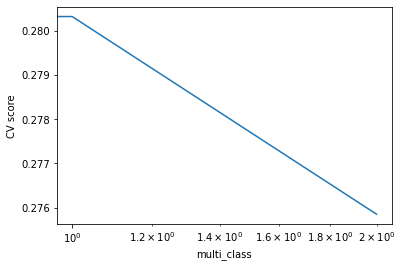

In [33]:
searcher_mc = GridSearchCV(model_, param_grid={'multi_class': multi_class}, scoring=beta_scorer, cv=4)
searcher_mc.fit(X_train_new_s, y1_train)
best_mc = searcher_mc.best_params_['multi_class']
print('best_multi_class: = ', best_mc)
plt.plot(multi_class, searcher_mc.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("multi_class")
plt.ylabel("CV score");

Будем также подбирать weights

In [74]:
keys = [1, 0]
weights_1 = (np.linspace(0, 1, 31))
weights_0 = 1 - weights_1
arr_w = np.array([weights_1, weights_0])
arr_w #array with weights
d = pd.DataFrame(columns=[1, 0])
d[1] = weights_1
d[0] = weights_0
d = round(d, 2)
dict_weights = d.to_dict(orient='records') #удобно разделяем датафрейм на кучу словарей

In [39]:
logreg_weights = GridSearchCV(model_, param_grid={
    'class_weight': dict_weights
}, scoring=beta_scorer, cv=4, return_train_score=True)

logreg_weights.fit(X_train_new_s, y1_train)
best_weights = logreg_weights.best_params_['class_weight']
y1_pred = logreg_weights.predict(X_test_new_s)
p_pred = logreg_weights.predict_proba(X_test_new_s)
p_pred = p_pred[:, -1]

print('F_beta score:', fbeta_score(y1_test, y1_pred, beta=5))

F_beta score: 0.7887351778656125


Построим модель по полученным параметрам

In [40]:
model_opt = LogisticRegression(solver='newton-cg', penalty=best_penalty, C=best_C, tol=best_tol, intercept_scaling=best_is, max_iter=best_mi, multi_class=best_mc, class_weight=best_weights)
model_opt.fit(X_train_new_s, y1_train)
probs_opt = model_opt.predict_proba(X_test_new_s)
winner_opt = probs_opt[:, 1]
y1_pred_opt = model_opt.predict(X_test_new_s)

In [41]:
roc_auc_opt = roc_auc_score(y1_test, winner_opt)
accuracy_opt = accuracy_score(y1_test, y1_pred_opt)
precision_opt = precision_score(y1_test, y1_pred_opt)
recall_opt = recall_score(y1_test, y1_pred_opt)
print('ROC_AUC = %.4f' % roc_auc_opt)
print('accuracy = %.4f' % accuracy_opt)
print('precision = %.4f' % precision_opt)
print('recall = %.4f' % recall_opt)

ROC_AUC = 0.9232
accuracy = 0.7910
precision = 0.1591
recall = 0.9358


Теперь модель дает слишком много победителей

In [42]:
len(pd.DataFrame(y1_pred_opt)[pd.DataFrame(y1_pred_opt)[0] == 1])

1923

Скажем модели, чтобы она выбирала победителем в каждой гонке человека с наибольшей вероятностью из всех, кому она ставит 1

Произведем те же операции, что и ранее, для того, чтобы называть победителем человека с наибольшей вероятностью победы

In [97]:
res_opt = pd.DataFrame((X_test.reset_index()).merge(pd.DataFrame(winner_opt), right_index=True, left_index=True))
res_opt.rename(columns={0: 'prob_win_predicted'}, inplace=True)
res_opt = res_opt.merge(pd.DataFrame(y1_pred_opt), right_index=True, left_index=True)
res_opt.rename(columns={0: 'win_predicted'}, inplace=True)

In [98]:
max_prob_win_opt = pd.DataFrame(res_opt.groupby('raceId')['prob_win_predicted'].max())

In [99]:
max_prob_win_opt.rename(columns={'prob_win_predicted': 'max_prob_win'}, inplace=True)
res_opt = res_opt.merge(max_prob_win_opt, right_index=True, left_on='raceId', how='outer')

будем оставлять только победителя с максимальной вероятностью победы

In [100]:
res_opt.loc[res_opt['win_predicted'] == 1, 'winner'] = 1

In [101]:
num_win = pd.DataFrame(res_opt.groupby('raceId')['winner'].sum())

In [102]:
num_win.rename(columns={'winner': 'num_win'}, inplace=True)
res_opt = res_opt.merge(num_win, right_index=True, left_on='raceId', how='outer')

In [103]:
res_opt.loc[(res_opt['num_win'] > 1)&(res_opt['prob_win_predicted'] == res_opt['max_prob_win']), 'winner_2'] = 1

In [104]:
res_opt['winner_2'].fillna(0, inplace=True)

In [105]:
res_opt.loc[(res_opt['num_win'] < 1)&(res_opt['prob_win_predicted'] == res_opt['max_prob_win']), 'winner_2'] = 1

In [106]:
len(res_opt[res_opt['winner_2'] == 1])

321

In [107]:
roc_auc = roc_auc_score(y1_test, winner_opt)
accuracy = accuracy_score(y1_test, res_opt['winner_2'])
precision = precision_score(y1_test, res_opt['winner_2'])
recall = recall_score(y1_test,  res_opt['winner_2'])
print('ROC_AUC = %.4f' % roc_auc)
print('accuracy = %.4f' % accuracy)
print('precision = %.4f' % precision)
print('recall = %.4f' % recall)

ROC_AUC = 0.9232
accuracy = 0.9523
precision = 0.4268
recall = 0.4190


Удалим ненужные колонки

In [108]:
res_opt.drop(['winner', 'num_win'], axis=1, inplace=True)

**Вывод:** мы предсказали вероятность победы для каждого гонщика, участвующего в гонке, а также пробовали подобрать лучший способ на основе этого называть победителя гонки. Оптимальным вариантом оказалось называть победителем человека с наибольшей вероятностью победы

## Предсказание подиумов

Кроме того, мы хотели предсказывать вероятность подиума для каждого гонщика

In [109]:
model2 = LogisticRegression()
model2.fit(X_train_new_s, y2_train)
probs = model2.predict_proba(X_test_new_s)
podium = probs[:, 1]
y2_pred = model2.predict(X_test_new_s)

In [110]:
roc_auc = roc_auc_score(y2_test, podium)
accuracy = accuracy_score(y2_test, y2_pred)
precision = precision_score(y2_test, y2_pred)
recall = recall_score(y2_test, y2_pred)
print('ROC_AUC = %.4f' % roc_auc)
print('accuracy = %.4f' % accuracy)
print('precision = %.4f' % precision)
print('recall = %.4f' % recall)

ROC_AUC = 0.9080
accuracy = 0.8937
precision = 0.6230
recall = 0.3909


In [111]:
res_opt = res_opt.merge(pd.DataFrame(podium), right_index=True, left_index=True)

Таким образом, мы добавили предсказанные нами вероятности подиума и победы для тестовой выборки

In [116]:
res_opt.rename(columns={0: 'prob_podium_predicted'}, inplace=True)